# Principal Components Analysis (PCA)

Peter Ralph

https://uodsci.github.io/dsci345

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd

rng = np.random.default_rng(1234)

$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}} \newcommand{\var}{\text{var}} \newcommand{\sd}{\text{sd}} \newcommand{\cov}{\text{cov}}$$
This is here so we can use `\P` and `\E` and `\var` and `\cov` and `\sd` in LaTeX below.

# When there's lots of variables

Suppose we have a bunch of data, like
$$ 
\begin{bmatrix}
X_{11} & X_{12} & \cdots & X_{1k} \\
X_{21} & X_{22} & \cdots & X_{2k}\\
\vdots & \vdots & \ddots & \vdots \\
X_{n1} & \cdots & \cdots &X_{nk}
\end{bmatrix}
$$
where
$$\begin{aligned}
    X_{i \cdot} &= \text{(one observation)} \\
    X_{\cdot j} &= \text{(one variable)} .
\end{aligned}$$

How do we "look" at it?
First, we look at all the variables separately and in pairs.
... what next?

One way to look at this is that we have $n$ points in $\mathbb{R}^k$.

Then, PCA answers the question:
"What are the most important axes of variation
(of the data in $\mathbb{R}^k$)?"

Let's start with an example.

# Manatee Morphometrics

Manatees come in different shapes and sizes.
In our morphometric study of manatees,
we will take 20 different measurements from each of 250 manatees:
head length, tail width, nostril spacing, belly diamter, etcetera.
Here's a rough model of the data:

- some manatees are bigger than others; this underlying "size" affects all variables roughly equally
- there are average shape differences between sexes in some variables

So, we'll:

1. choose the mean female minus male difference for each variable
2. generate the sex and relative size of each manatee
3. generate all measurements from independent Normals, adjusted by sex and size

In [2]:
k = 20
n = 250
sexes = np.array(['f', 'm'])[1 * (rng.random(size=n) < 0.5)]
sizes = rng.normal(loc=1.0, scale=0.2, size=n)

mean_measurements = rng.gamma(shape=10, scale=10, size=k)
sex_diffs = np.sort(rng.normal(loc=10, scale=25, size=k)) # female minus male
sd_measurements = 20

X = rng.normal(loc=mean_measurements, scale=sd_measurements, size=(n, k))
X[sexes == 'f', :] += sex_diffs
X *= sizes[:, np.newaxis]

What'd we just do?
$$\begin{aligned}
    \mu_j &= \text{(mean measurement for variable $j$)} \\
    d_j &= \text{(mean female minus male difference for variable $j$)} \\
    S_i &= \text{("size" of manatee $i$)} \\
        &\sim \text{Normal}(\text{mean}=1, \text{sd}=0.1) \\
    F_i &= \begin{cases}
        1 \qquad &\text{if manatee $i$ is female} \\
        0 \qquad &\text{otherwise}
    \end{cases} \\
    \epsilon_{ij} &\sim \text{Normal}(0, \sigma) \\
    X_{ij} &= \text{(measurement $j$ for manatee $i$)} \\
        &= S_i \left( \mu_j + d_j F_i + \epsilon_{ij} \right) .
\end{aligned}$$

As a result, the two sexes are only slightly offset on any axis (seen in pairwise scatter plots):

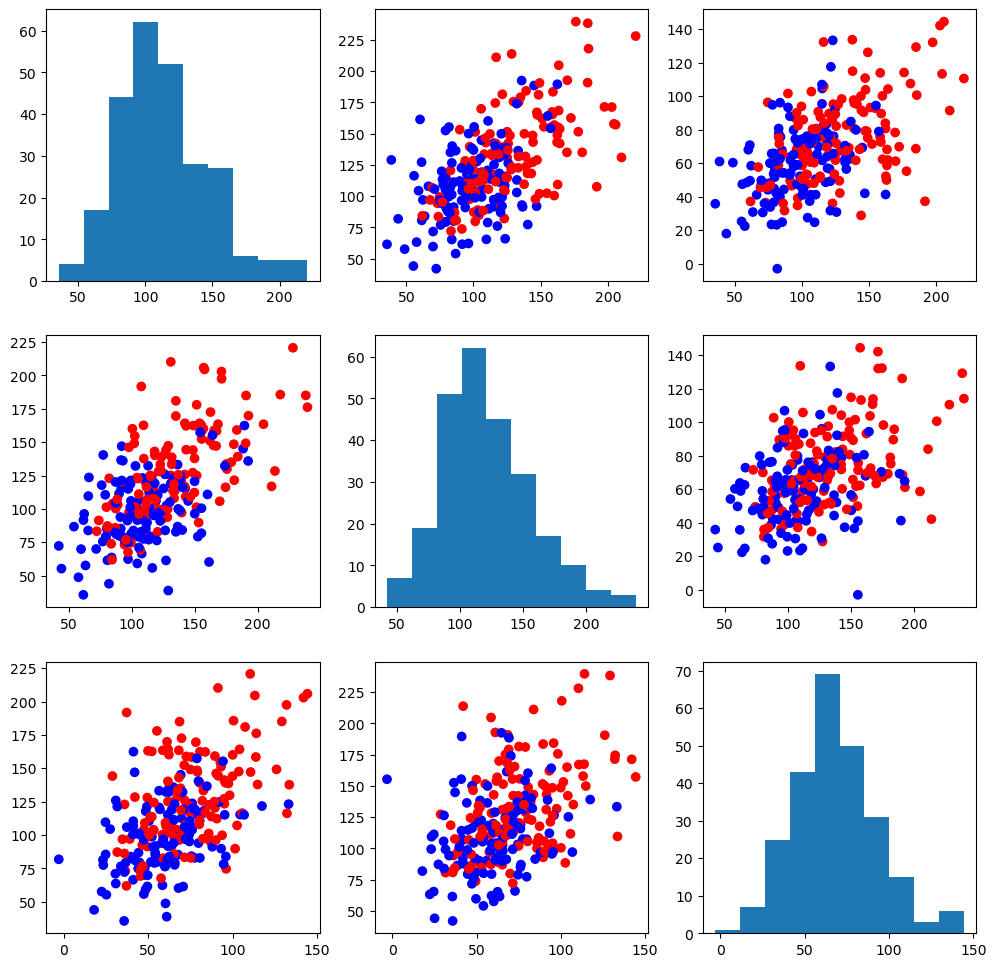

In [3]:
# PCA fig 1
colors = np.array(['r', 'b'])[1 * (sexes == 'f')]
fig, axes = plt.subplots(3, 3, figsize=(12,12))
for i in range(3):
    for j in range(3):
        ax = axes[i][j]
        if i == j:
            ax.hist(X[:,i])
        else:
            ax.scatter(X[:,i], X[:,j], c=colors)

First, we do PCA *(explanation later)*:

In [4]:
covmat = np.cov(X.T)
evals, evecs = np.linalg.eig(covmat)
eord = np.argsort(evals)[::-1]
evals = evals[eord]
evecs = evecs[:,eord]
pcs = X.dot(evecs)

## Scree plot

<div style="float: right; width: 40%;">
<img src="images/scree.png" alt="a steep scree slope (rocks below a cliff) in the mountains">
</div>


Larger eigenvalues are more important (in a way we'll explain later).
It turns out that the eigenvalue, squared, is proportional to
"the percent variation explained" by the corresponding PC.
Plotting these is referred as a "scree plot".

**Scree plot:**

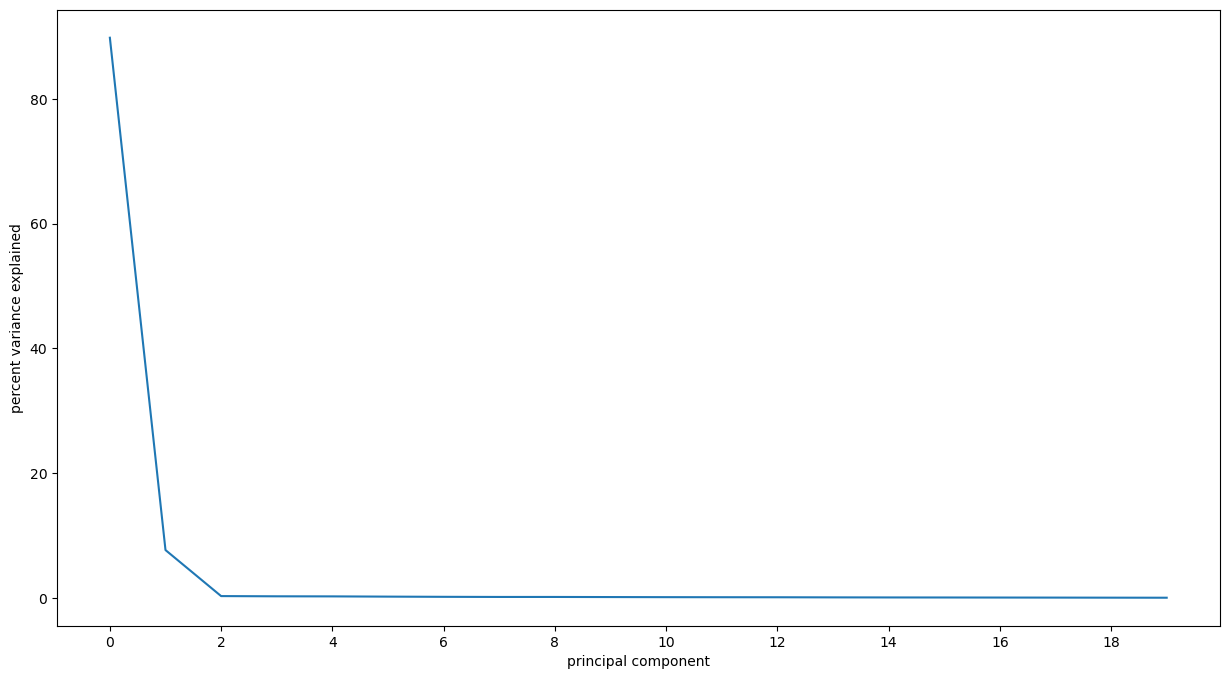

In [5]:
# PCA fig 2
perc_var = 100 * evals**2 / np.sum(evals**2)
plt.plot(perc_var)
plt.xlabel("principal component")
plt.ylabel("percent variance explained")
plt.xticks(np.arange(0, 20, 2));

## Manatees in PC space

Here is a plot of the (projections of each manatee on to the)
first two principal components,
colored by sex of the manatee.
The two sexes form nearly separated clouds,
both spread out along PC1 but
with females below males on PC2.

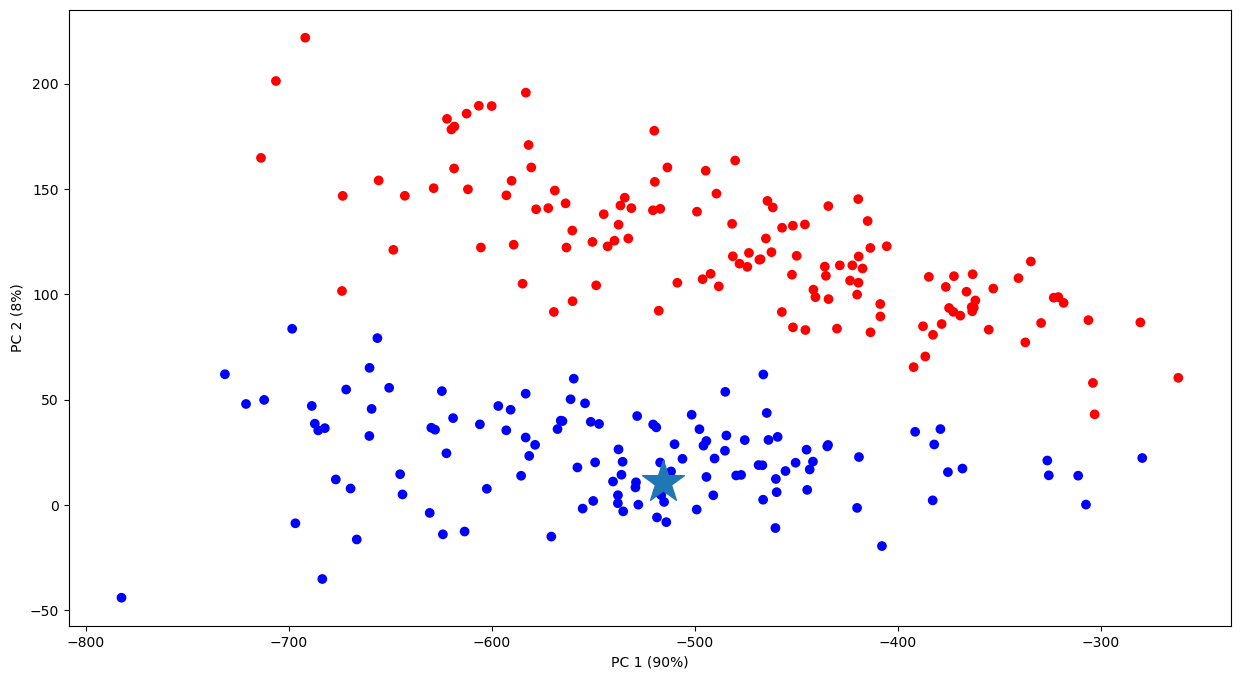

In [6]:
# PCA fig 3
plt.scatter(pcs[:,0], pcs[:,1], c=np.array(['red', 'blue'])[1*(sexes == 'f')])
plt.scatter(pcs[0,0], pcs[0,1], marker="*", s=1000) # manatee number 0
plt.xlabel(f"PC 1 ({perc_var[0]:.0f}%)"); plt.ylabel(f"PC 2 ({perc_var[1]:.0f}%)");

# "PC1 is size"

What is PC1 telling us? PC1 value and the avarage measurement (as a proxy for "size") are highly (negatively) correlated:

In [ ]:
# PCA fig 4
plt.scatter(pcs[:,0], np.mean(X, axis=1))
plt.xlabel("PC1"); plt.ylabel("average measurement");

## How variables contribute to each PC

Each PC is a linear combination of the 20 measurements;
these coefficients are called the "loadings".
Here these are for the first two PCs: PC1 is nearly constant (and negative),
while PC2 starts positive and decreases to be negative
(which makes sense because we sorted the sex effects of each variable).

In [ ]:
# PCA fig 5
for k in np.arange(2):
    plt.plot(evecs[:, k], label=f"PC{k+1}")

plt.xlabel("variable number")
plt.ylabel("coefficient in the PC")
plt.legend();

# What's happening: the math

## The Principal Components

Suppose that $X$ is $k$-dimensional with $\E[X] = 0$ and
$$ \cov[X] = C .$$

Say we want to combine a bunch of these variables
into a new, composite variable:
take coefficients $a = (a_1, \ldots, a_{k})$
and define $Y = a \cdot X = \sum_{i=1}^k a_i X_i$.

What is $\var[Y]$?

Since $\E[X] = \E[Y] = 0$,
$$\begin{aligned}
    \var[Y] &= \E[Y^2] \\
        &= \E\left[ \left(\sum_{i=1}^k a_i X_i \right)^2 \right] \\
        &= \E\left[ \sum_{i=1}^k \sum_{j=1}^k a_i a_j X_i X_j \right] \\
        &= \sum_{i=1}^k \sum_{j=1}^k a_i a_j \E\left[ X_i X_j \right] \\
        &= \sum_{i=1}^k \sum_{j=1}^k a_i a_j C_{ij} \\
        &= a^T C a .
\end{aligned}$$

*Which choice of coefficients, $a$, maximizes the variance of $Y = a \cdot X$?*

The *top eigenvector* of the covariance matrix, $C$.

*Which choice of coefficients $b$ maximizes the variance of $Z = b \cdot X$,
for $b$ such that $\cov[Y, Z] = 0$?*

The second eigenvector of the covariance matrix.

*Linear algebra fact:*
If $\lambda_i$ and $v_i$ are the $i^\text{th}$ eigenvalue and eigenvector of $C$,
with $\|v_i\| = 1$,
then
$$
    C = \sum_{i=1}^k \lambda_i v_i v_i^T .
$$
Furthermore, since $C$ is symmetric, $v_i \cdot v_j = \delta_{ij}$, and
$$
    \sum_{ij} C_{ij}^2 = \sum_i \lambda_i^2 .
$$

*Said another way:*
If we change into the basis given by the eigenvectors,
$C$ is diagonal,
and this change of basis is *orthogonal* (i.e., it preserves distances).

**Terminology:**

- $(v_i \cdot X)$: the $i^\text{th}$ principal component, PC$i$
- $v_i$: the *loadings* of PC$i$ on each variable
- $\lambda_i^2$: the amount of *variance explained* by PC$i$

So, what'd we do?

Find the covariance matrix:
```
covmat = np.cov(X.T)
```

Get the eigenvalues and eigenvectors:
```
evals, evecs = np.linalg.eig(covmat)
```

Sort them by size of eigenvalue:
```
eord = np.argsort(evals)[::-1]
evals = evals[eord]
evecs = evecs[:,eord]
```

Change the data matrix into the basis given by the eigenvectors:
```
pcs = X.dot(evecs)
```

Find the percent variance explained by each PC:
```
perc_var = 100 * evals**2 / np.sum(evals**2)
```

# Example: text analysis

In [`data/passages.txt`](data/passages.txt)
we have a number of short passages from a few different books.

Can we identify the authors of each passage?

The true sources of the passages are in [data/passage_sources.tsv](data/passage_sources.tsv).

## Turn the data into a matrix

In [ ]:
from collections import defaultdict

pfile = open("data/passages.txt", "r")
passages = pfile.read().split("\n")[:-1]
sources = pd.read_table("data/passage_sources.tsv")
words = np.unique(" ".join(passages).split(" "))[1:]
def tabwords(x, words):
    d = defaultdict(int)
    for w in x.split(" "):
        d[w] += 1
    out = np.array([d[w] for w in words])
    return out

wordmat = np.array([tabwords(x, words) for x in passages])

In [ ]:
passages[1]

In [ ]:
for w, x in zip(words[:20], wordmat[:20,:].T):
    print(f"{w}: {x}")

This time we "do PCA" by finding the "singular value decomposition"
(SVD) of the data matrix,
because `scipy.sparse.linalg.svds` lets us *only*
find the PCs we're interested in:
finding *all* would take waaaay too long.

In [ ]:
from scipy.sparse.linalg import svds
# center and scale the data
x = wordmat - np.mean(wordmat, axis=1)[:,np.newaxis]
x /= np.std(x, axis=1)[:, np.newaxis]
pcs, evals, evecs = svds(x, k=3)
eord = np.argsort(evals)[::-1]
evals = evals[eord]
evecs = evecs[eord,:]
pcs = pcs[:,eord]

## The loadings

In [ ]:
loadings = pd.DataFrame(evecs.T, columns=[f"PC{k}" for k in range(1,4)], index=words)
loadings

## The PCs

In [ ]:
# PCA fig 6 & 7
fig, (ax0, ax1) = plt.subplots(1, 2)
for s in np.unique(sources['source']):
    ax0.scatter(pcs[sources['source'] == s,0], pcs[sources['source'] == s,1])
    ax1.scatter(pcs[sources['source'] == s,1], pcs[sources['source'] == s,2], label=s)

ax0.set_xlabel("PC 1"); ax0.set_ylabel("PC 2")
ax1.set_xlabel("PC 2"); ax1.set_ylabel("PC 3")
ax1.legend();

## PC 1 is length

In [ ]:
# PCA fig 8
lengths = np.sum(wordmat, axis=1)
for s in np.unique(sources['source']):
    plt.scatter(
        pcs[sources['source'] == s, 0],
        lengths[sources['source'] == s]
    )
plt.legend();
plt.xlabel("PC1"); plt.ylabel("passage length");

## PC2 is book

In [ ]:
loadings.sort_values("PC2").head(20)

In [ ]:
loadings.sort_values("PC2 ").tail(20)

## PC3?

In [ ]:
loadings.sort_values("PC3").head(20)

In [ ]:
loadings.sort_values("PC3").tail(20)